# Connectome pipeline
This tutorial shows how to use the NIAK connectome pipeline to generate seed-based functional connectivity maps on the COBRE sample. See the [documentation](http://niak.simexp-lab.org/pipe_connectome.html) of the pipeline for a more detailed description of the options. Download the tutorial as a notebook [here](https://raw.githubusercontent.com/SIMEXP/niak_tutorials/master/connectome/niak_tutorial_rmap_connectome.ipynb) and a matlab script [here](https://raw.githubusercontent.com/SIMEXP/niak_tutorials/master/connectome/niak_tutorial_rmap_connectome.m). To run this tutorial, we recommend to use [jupyter](http://jupyter.org/) from a niak docker container, as described in the [NIAK installation page](http://niak.simexp-lab.org/niak_installation.html). 

## Preparing files

### Functional MRI 
First download a small preprocessed fMRI dataset. 

In [1]:
clear
path_data = [pwd filesep];
[status,msg,data_fmri] = niak_wget('single_subject_cambridge_preprocessed_nii');

When starting from fMRI data preprocessed with NIAK, it is possible to use `niak_grab_fmri_preprocess` on the output folder to collect the file names, as described in the [pipeline documentation](http://niak.simexp-lab.org/pipe_connectome.html). In this case there is a single fMRI file, and we explicitely list it for the pipeline: 

In [2]:
files_in = struct;
files_in.fmri.subject1.sess1.rest = [data_fmri.path filesep 'fmri_sub00156_session1_rest.nii.gz'];

### Brain parcellation
The second input of the pipeline is a set of brain parcels. We will just download the so-called Cambridge functional template. 



In [3]:
[status,msg,data_template] = niak_wget('cambridge_template_mnc1');

We are going to pick the parcellation into 7 distributed networks.

In [4]:
files_in.network = [data_template.path filesep 'template_cambridge_basc_multiscale_sym_scale007.mnc.gz'];

### List of seeds

The next step is to generate a list of seeds. This requires creating a text file that looks like:
```
        , index
 MOTOR  , 3
 DMN    , 5
```
We are going to use NIAK's tool to write comma-separated values (CSV) in a file:

In [5]:
files_in.seeds = [path_data 'list_seeds.csv'];
opt_csv.labels_x = { 'MOTOR' , 'DMN' }; % The labels for the network
opt_csv.labels_y = { 'index' };
tab = [3 ; 5];
niak_write_csv(files_in.seeds,tab,opt_csv);

## Set the options of the pipeline
Now we set up where to store the results:

In [6]:
opt.folder_out = [path_data 'connectome'];

We set options such that we will not generate graph properties, just the correlation maps:

In [7]:
opt.flag_p2p = false; % No parcel-to-parcel correlation values
opt.flag_global_prop = false; % No global graph properties
opt.flag_local_prop  = false; % No local graph properties
opt.flag_rmap = true; % Generate correlation maps

## Run the pipeline
Now let's run the pipeline:

In [8]:
opt.flag_test = false; 
[pipeline,opt] = niak_pipeline_connectome(files_in,opt); 

Adding seed MOTOR (parcel number 3)
Adding seed DMN (parcel number 5)

Logs will be stored in /sandbox/home/git/niak_tutorials/connectome/connectome/logs/
Generating dependencies ...
   Percentage completed :  20 40 60 80 100- 0.01 sec
Setting up the to-do list ...
   I found 5 job(s) to do.
I could not find any log file. This pipeline has not been started (yet?). Press CTRL-C to cancel.
Deamon started on 21-Nov-2016 02:33:44
21-Nov-2016 02:33:44 Starting the pipeline manager...
21-Nov-2016 02:33:44 Starting the garbage collector...
21-Nov-2016 02:33:44 Starting worker number 1...
21-Nov-2016 02:33:44 Starting worker number 2...
21-Nov-2016 02:33:44 Starting worker number 3...
21-Nov-2016 02:33:44 Starting worker number 4...

Pipeline started on 21-Nov-2016 02:33:45
user: , host: 43c4ef2130b0, system: unix
****************************************
21-Nov-2016 02:33:46 mask_rois           submitted  (1 run / 0 fail / 0 done / 4 left)
21-Nov-2016 02:33:54 mask_rois           finished   (0

# Reviewing outputs

All the correlation maps have been generated in the subfolder called `rmap_seeds`, inside the output folder. We can have a quick look at them. Note that the files have been named using the identification codes we used in `files_in.fmri`, and well as in the file `files_in.seeds`.  

In [9]:
file_dmn   = [opt.folder_out filesep 'rmap_seeds' filesep 'rmap_subject1_DMN.nii.gz'];
file_motor = [opt.folder_out filesep 'rmap_seeds' filesep 'rmap_subject1_MOTOR.nii.gz'];
[hdr,rmap_dmn]   = niak_read_vol(file_dmn);
[hdr,rmap_motor] = niak_read_vol(file_motor);
size(rmap_dmn)
size(rmap_motor)

ans =

   53   64   52

ans =

   53   64   52



We will now use `niak_vol2img` to generate a series of axial slices for both maps. 

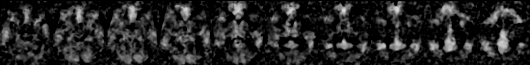

In [10]:
% The default-mode network
coord = linspace(-20,40,10)';
coord = repmat(coord,[1 3]);
opt_v = struct;
opt_v.type_view = 'axial';
img_dmn = niak_vol2img(hdr,rmap_dmn,coord,opt_v);
imshow(img_dmn,[0,1])

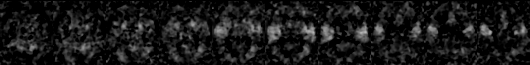

In [11]:
% The sensorimotor network
img_motor = niak_vol2img(hdr,rmap_motor,coord,opt_v);
imshow(img_motor,[0,1])

There are also two files which contain the seeds as binary masks. E.g.:

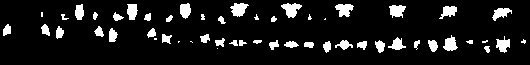

In [12]:
file_mask_dmn   = [opt.folder_out filesep 'rmap_seeds' filesep 'mask_DMN.nii.gz'];
[hdr,mask_dmn]   = niak_read_vol(file_mask_dmn);
img_mask_dmn = niak_vol2img(hdr,mask_dmn,coord,opt_v);
imshow(img_mask_dmn,[0,1])

Finally, note that there are two files containing the average correlation maps (e.g. `average_rmap_DMN.nii.gz` for the DMN), across all subjects. But as we have only one subject here, these maps are identical to individual maps.